# Validation gradient wind balance

In [1]:
import os

import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import numpy as np
import xgcm
from oceanpy import gradient_wind_from_ssh, define_grid, horizontal_divergence, horizontal_strain, relative_vorticity

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

import cmocean as cmo
import string

In [2]:
figsdir = os.path.join(os.sep, 'g', 'data', 'v45', 'jm6603', 'checkouts', 'phd-figs', 'manuscripts', '02_manuscript')
outdir = os.path.join(os.sep, 'g', 'data', 'v45', 'jm6603', 'checkouts', 'phd', 'src', 'cosima', '02_manuscript', 'output')

In [3]:
fs_small = 18
fs_large = 20
plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('axes', labelsize=fs_large)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
plt.rc('text', usetex=False)

savefig = False

## Load and select data

In [4]:
lon_lim = slice(-224, -212.5)
lat_lim = slice(-53.5, -47.5)

# Load coordinates
file_name = os.path.join(outdir, 'coordinates.nc')
ds = xr.open_dataset(file_name)
ds_sel = ds.sel(
    xt_ocean=lon_lim, yt_ocean=lat_lim,
    xu_ocean=lon_lim, yu_ocean=lat_lim)
coordinates = ds_sel.assign_coords(
    xt_ocean=((ds_sel.xt_ocean + 180) % 360) - 180,
    xu_ocean=((ds_sel.xu_ocean + 180) % 360) - 180)

# Load gradient wind data
file_name = os.path.join(outdir, 'gw-vel.nc')
ds_gw = xr.open_dataset(file_name).sel(
    xt_ocean=lon_lim, yt_ocean=lat_lim)
gw_vel = ds_gw.assign_coords(
    xt_ocean=((ds_gw.xt_ocean + 180) % 360) - 180)

# Load geostrophic velocity data
file_name = os.path.join(outdir, 'geos-vel.nc')
ds_geos = xr.open_dataset(file_name).sel(
    xt_ocean=lon_lim, yt_ocean=lat_lim, 
    xu_ocean=lon_lim, yu_ocean=lat_lim)
geos_vel = ds_geos.assign_coords(
    xt_ocean=((ds_geos.xt_ocean + 180) % 360) - 180,
    xu_ocean=((ds_geos.xu_ocean + 180) % 360) - 180)
geos_vel = geos_vel.drop_vars(['deltaD', 'D', 'g', 'gu', 'f', 'ures', 'vres', 'Vres', 'Vg_s', 'Vg'])

# Load velocity data
file_name = os.path.join(outdir, 'vel.nc')
ds_vel = xr.open_dataset(file_name).sel(
    xt_ocean=lon_lim, yt_ocean=lat_lim, 
    xu_ocean=lon_lim, yu_ocean=lat_lim)
vel = ds_vel.assign_coords(
    xt_ocean=((ds_vel.xt_ocean + 180) % 360) - 180,
    xu_ocean=((ds_vel.xu_ocean + 180) % 360) - 180)

flex_period = slice('1997-04-10', '1997-04-25')
meander_period = slice('1997-02-15', '1997-05-31')

## Define grid

In [5]:
# define coordinates
coords = {'xt_ocean': None, 'yt_ocean': None, 'st_ocean': None, 'xu_ocean': 0.5, 'yu_ocean': 0.5}
distances=('dxt', 'dyt', 'dxu', 'dyu')
areas=('area_u', 'area_t')
dims=('X', 'Y')

# vel = xr.merge([coordinates, vel])

grid = define_grid(geos_vel, dims, coords, distances, areas, periodic=False)
grid

<xgcm.Grid>
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> inner
  * inner    yu_ocean --> center

## Gradient wind, geostrophic and ageostrophic velocities

In [6]:
# vel_sel = xr.merge([coordinates, V, u, v])
gw_sel = gw_vel.sel(time=flex_period)
geos_sel = geos_vel.sel(time=flex_period)


## Validate gradient wind velocity

In [7]:
# Calculate flow speed
V = np.sqrt(geos_sel.u**2 + geos_sel.v**2)

# Interpolate total surface velocity to t-cells
u_t = grid.interp(grid.interp(geos_sel.u, 'Y', boundary='extend'), 'X', boundary='extend')
v_t = grid.interp(grid.interp(geos_sel.v, 'Y', boundary='extend'), 'X', boundary='extend')
V_t = np.sqrt(u_t**2 + v_t**2)
u_t.name, v_t.name, V_t.name = 'u_t', 'v_t', 'V_t'

# Interpolate geostrophic velocity to t-cells
ug_t = grid.interp(grid.interp(geos_sel.ug, 'Y', boundary='extend'), 'X', boundary='extend')
vg_t = grid.interp(grid.interp(geos_sel.vg, 'Y', boundary='extend'), 'X', boundary='extend')
Vg_t = np.sqrt(ug_t**2 + vg_t**2)
ug_t.name, vg_t.name, Vg_t.name = 'ug_t', 'vg_t', 'Vg_t'

# Calculate velocity difference total and geostrophic velocities
dug, dvg = u_t - ug_t, v_t - vg_t
dVg = np.sqrt(dug**2 + dvg**2)
dug.name, dvg.name, dVg.name = 'dug', 'dvg', 'dVg'

# Calculate velocity difference between total and surface gradient wind velocities
dugw, dvgw = u_t.isel(st_ocean=0) - gw_vel.ugw, v_t.isel(st_ocean=0) - gw_vel.vgw
dVgw = np.sqrt(dugw**2 + dvgw**2)
dugw.name, dvgw.name, dVgw.name = 'dugw', 'dvgw', 'dVgw'

vel_comb = xr.merge([coordinates, gw_sel, u_t, v_t, V_t, dug, dvg, dVg, dugw, dvgw, dVgw])

In the plot below we see the gradient wind speed calculated from the sea surface height in the top left. The Rossby number in the top right, calculated as the ratio of the the ageostrophioc velocity over the gradien wind velocity.

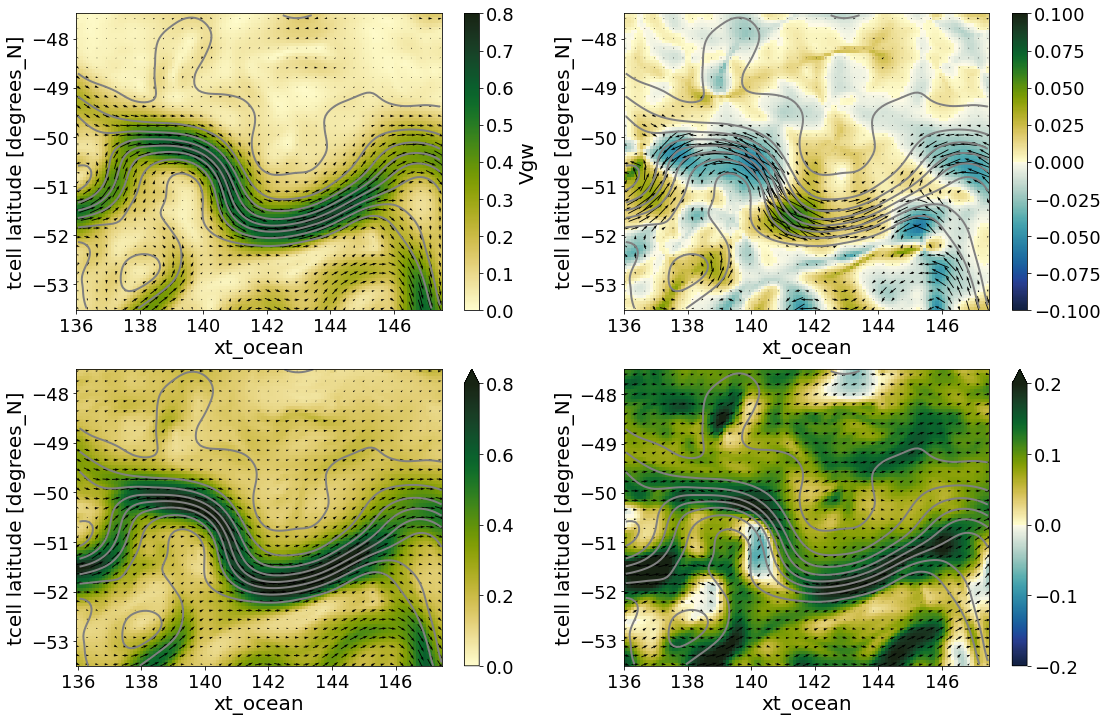

In [8]:
nrows, ncols = 2, 2
slc = xt_ocean=slice(None, None, 3)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,12))

# Plot gradient wind speed
gw_sel.Vgw.mean('time').plot(ax=ax[0, 0], cmap=cmo.cm.speed, vmin=0, vmax=0.8)
gw_sel.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[0, 0], x='xt_ocean', y='yt_ocean', u='ugw', v='vgw')

# Plot Rossby number (ratio ageostrophic over gradient wind speed)
((gw_sel.Vgw - gw_sel.Vg) / gw_sel.Vgw).mean('time').plot(ax=ax[0, 1], cmap=cmo.cm.delta, vmin=-0.1, vmax=0.1)
gw_sel.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[0, 1], x='xt_ocean', y='yt_ocean', u='uag', v='vag')

# Plot total surface flow speed
V.isel(st_ocean=0).mean('time').plot(ax=ax[1, 0], cmap=cmo.cm.speed, vmin=0, vmax=0.8)
geos_vel.isel(st_ocean=0).mean('time').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax[1, 0], x='xu_ocean', y='yu_ocean', u='u', v='v')

# Plot difference between total and gradient wind flow speed
(V_t.isel(st_ocean=0) - gw_sel.Vgw).mean('time').plot(ax=ax[1, 1], cmap=cmo.cm.delta, vmin=-0.2, vmax=0.2)
vel_comb.isel(st_ocean=0).mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[1, 1], x='xt_ocean', y='yt_ocean', u='dugw', v='dvgw', color='k')


# Plot sea level contours
sl_contours = np.linspace(-0.7, 0, 8)
for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols
    cont = gw_sel.sea_level.mean('time').plot.contour(
            ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=2, colors='gray')

a. The difference between the total and the gradient wind velocity. b. The difference between the total and the geostrophic velocity at the surface and c. at 200 m depth.

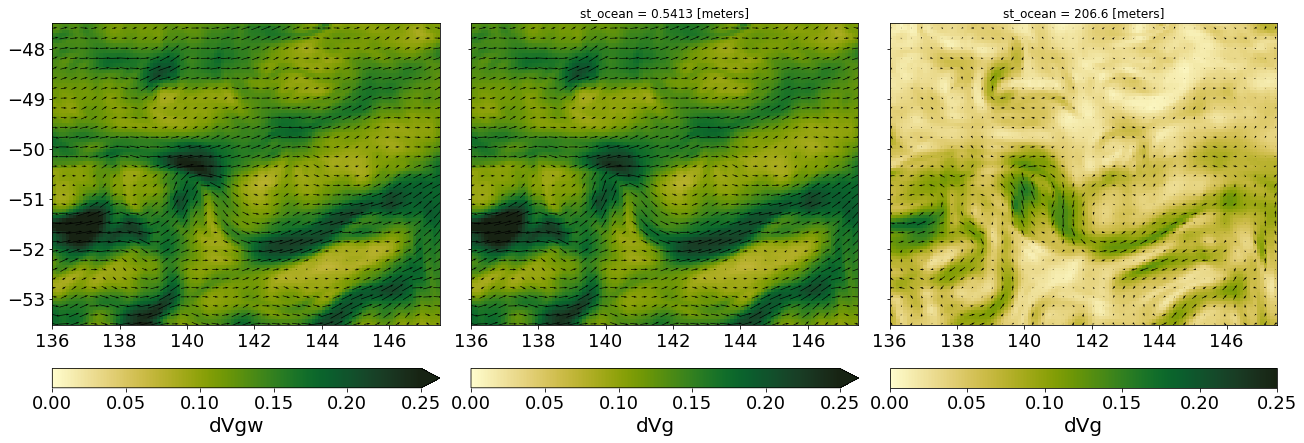

In [9]:
st_ocean_isel = 30

fig, ax = plt.subplots(ncols=3, figsize=(18,6), sharey=True, constrained_layout=True)

vel_comb.mean('time').dVgw.plot(ax=ax[0], vmin=0, vmax=0.25, cmap=cmo.cm.speed, cbar_kwargs={"location": "bottom"})
quiv = vel_comb.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[0], x='xt_ocean', y='yt_ocean', u='dugw', v='dvgw', 
    units='inches', scale=1, width=5e-4*fig.get_size_inches()[0], add_guide=False)

vel_comb.mean('time').isel(st_ocean=0).dVg.plot(ax=ax[1], vmin=0, vmax=0.25, cmap=cmo.cm.speed, cbar_kwargs={"location": "bottom"})
quiv = vel_comb.mean('time').isel(st_ocean=0).sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[1], x='xt_ocean', y='yt_ocean', u='dug', v='dvg', 
    units='inches', scale=1, width=5e-4*fig.get_size_inches()[0], add_guide=False)

vel_comb.mean('time').isel(st_ocean=st_ocean_isel).dVg.plot(ax=ax[2], vmin=0, vmax=0.25, cmap=cmo.cm.speed, cbar_kwargs={"location": "bottom"})
quiv = vel_comb.mean('time').isel(st_ocean=st_ocean_isel).sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[2], x='xt_ocean', y='yt_ocean', u='dug', v='dvg', 
    units='inches', scale=1, width=5e-4*fig.get_size_inches()[0], add_guide=False)

for iax in range(ax.size):
    ax[iax].set_xlabel('')
    ax[iax].set_ylabel('')

In [10]:
# zeta_ag = relative_vorticity(vel_comb, grid, vel_names=('dug', 'dvg'), delta_names=('dxu', 'dyu'))
# zeta_ag.mean('time').isel(st_ocean=st_ocean_isel).plot.contour(levels=[-0.5e-5, -0.25e-5, 0, 0.25e-5, 0.5e-5])

## Horizontal divergence from gradient wind balance at sea level

$$ \nabla_h \times {\bf u} = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} $$

Gradient wind balance
$$\kappa{|\textbf{u}|}^2 + f|\textbf{u}| = g{\bf \hat{k}} \times \nabla \eta$$

Gradient wind speed is the combination of geostrophic and ageostrophic velocities

$$\textbf{u} = {\bf u_g}+ {\bf u_a}$$

Divergence in the flow field is due to ageostrophy velocities (geostrophic flow is divergence free)

$$\frac{\partial u_a}{\partial x} + \frac{\partial v_a}{\partial y}$$

In [11]:
plt.rcParams.update(plt.rcParamsDefault)

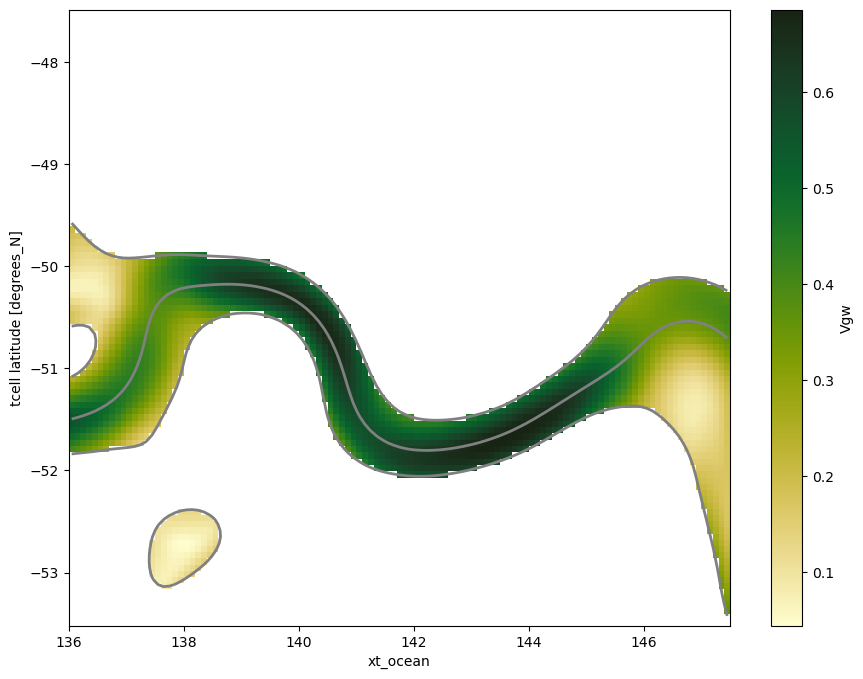

In [12]:
core_contour = -0.4
sl_contours = [core_contour-0.2, core_contour, core_contour+0.2]
gwmean = gw_sel.mean('time')
gwmean.Vgw.where(
    (gwmean.sea_level > sl_contours[0]) & 
    (gwmean.sea_level < sl_contours[-1])).plot(size=8, cmap=cmo.cm.speed)
cont = gwmean.sea_level.plot.contour(
    levels=sl_contours, linestyles='solid', linewidths=2, colors='gray')

In [13]:
# calculate horizontal divergence for total and ageostrophic flow field due to gradient wind
div_u = horizontal_divergence(geos_sel, grid, vel_names=('u', 'v'), delta_names=('dxt', 'dyt'))
# div_u = div_u.assign_coords(xu_ocean=(((ds.xu_ocean + 180) % 360) - 180))
div_u.name = 'divu'
div_u.attrs['long_name'] = r"$\nabla_h \cdot u$"
ds = xr.merge([ds, div_u])

div_ut = grid.interp(grid.interp(div_u, 'Y', boundary='extend'), 'X', boundary='extend')
div_ut.name = 'divu'
div_ut.attrs['long_name'] = r'$\nabla_h \cdot u$'

div_u_gw = horizontal_divergence(vel_comb, grid, vel_names=('uag', 'vag'), delta_names=('dxu', 'dyu'))
div_u_gw.name = 'divua'
div_u_gw.attrs['long_name'] = r'$\nabla_h \cdot u_a$'
vel_div = xr.merge([vel_comb, div_u_gw, div_ut])

In [14]:
# fig, ax = plt.subplots(figsize=(16, 16))

# for depth in [0, 30, 200]:
#     sel = gw_core.sel(st_ocean=depth, method='nearest')
#     sel.plot.scatter(ax=ax, x='divua', y='divu', s=10, label=sel.st_ocean.values)
# x= np.linspace(-4e-6, 4e-6)
# ax.plot(x, x, '--', color='k', lw=0.5)
# ax.set_xlim([-1.5e-6, 1.5e-6])
# ax.set_ylim([-1.5e-6, 1.5e-6])
# fig.legend()

## Manuscript figure

In [15]:
def linear_fit(x, y):

    x = np.ma.masked_invalid(x).flatten()
    y = np.ma.masked_invalid(y).flatten()

    mask = x.mask | y.mask
    pf = np.polyfit(x[~mask],y[~mask], 1)
    f = np.poly1d(pf)

    return x, f(x)

def Rsquared(var_x, var_y, mask=None):
    
    mask_x, mask_y = np.ma.masked_invalid(var_x).mask, np.ma.masked_invalid(var_y).mask
    mask = np.zeros(mask_x.shape, dtype=bool) if mask is None else mask
    mask = mask | mask_x | mask_y

    coef = np.polyfit(var_x[~mask], var_y[~mask], 1)
    f = np.poly1d(coef)
    
    # coefficient of determination
    SSres = np.sum((var_y[~mask] - f(var_x)[~mask])**2)
    SStot = np.sum((var_y[~mask] - np.nanmean(var_y[~mask]))**2)
    
    R2 = 1 - (SSres/SStot)
    
    return R2, f

In [16]:
# plt.rcParams.update({"text.usetex": True, "font.family": 'serif', "font.serif": 'cm'})
# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"text.usetex": True, "font.family": 'serif', "font.serif": 'cm', 'font.size': fs_small})


Text(0, 0.5, '')

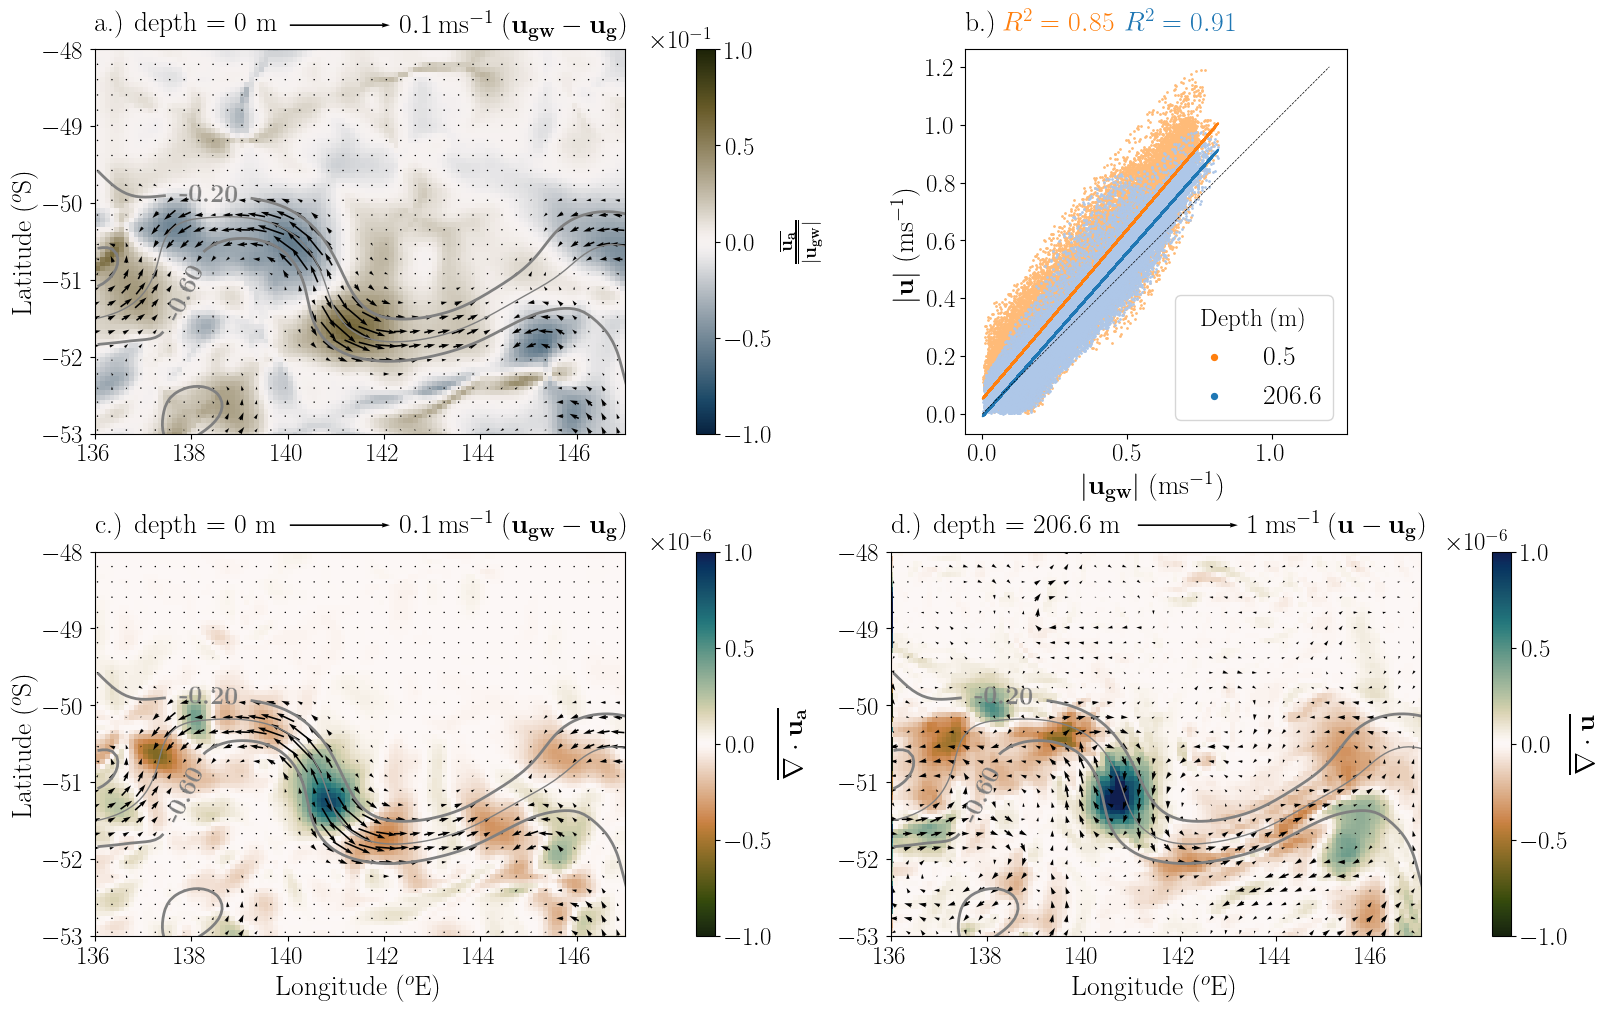

In [17]:
nrows, ncols = 2, 2
slc = xt_ocean=slice(None, None, 3)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,10), constrained_layout=True)

# plot Rossby number (ratio ageostrophic over gradient wind speed)
pcol = ((vel_comb.Vgw - vel_comb.Vg) / vel_comb.Vgw).mean('time').plot(
    ax=ax[0, 0], cmap=cmo.cm.diff, vmin=-0.1, vmax=0.1, extend='both', add_colorbar=False)
cbar = fig.colorbar(pcol, ax=ax[0, 0])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.set_ylabel(r'$\frac{\overline{\bf u_a}}{\overline{|{\bf u_{gw}}|}}$', fontsize=fs_large)

quiv = vel_comb.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[0, 0], x='xt_ocean', y='yt_ocean', u='uag', v='vag',
    units='inches', scale=0.1, width=1e-3*fig.get_size_inches()[0], add_guide=False)
qk = plt.quiverkey(quiv, 0.24, 0.98, 0.1, r'$0.1\:\mathrm{ms}^{-1}\:({\bf u_{gw} - u_g})$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})

# scatter
colors = ['tab:orange', 'tab:blue', 'tab:green']
# gw_surf = gwmean.isel(st_ocean=0).where(
#     (gwmean.sea_level > -0.6) & (gwmean.sea_level < -0.1))
gw_surf = vel_comb.isel(st_ocean=0).where(
    (vel_comb.sea_level > sl_contours[0]) & (vel_comb.sea_level < sl_contours[-1]))
gw_surf.plot.scatter(
    ax=ax[0, 1], x='Vgw', y='V_t', s=1, color=plt.cm.get_cmap('tab20').colors[3], #mcolors.to_rgba(colors[0], 0.1),
    label=np.round(gw_surf.st_ocean.values,1))
ax[0, 1].plot(*linear_fit(gw_surf.Vgw, gw_surf.V_t), color=colors[0])
i=0
ax[0, 1].text(0.32*i+0.1, 1.05, r'$R^2 = %s$' %np.round(Rsquared(gw_surf.Vgw.values, gw_surf.V_t.values)[0], 2), 
              transform=ax[0, 1].transAxes, fontsize=fs_large, color=colors[i])

# gw_mld = gwmean.isel(st_ocean=st_ocean_isel).where(
#     (gwmean.sea_level > -0.6) & (gwmean.sea_level < -0.1))
gw_mld = vel_comb.isel(st_ocean=st_ocean_isel).where(
    (vel_comb.sea_level > sl_contours[0]) & (vel_comb.sea_level < sl_contours[-1]))
gw_mld.plot.scatter(
    ax=ax[0, 1], x='Vgw', y='V_t', s=1, color=plt.cm.get_cmap('tab20').colors[1], 
    label=np.round(gw_mld.st_ocean.values,1))
ax[0, 1].plot(*linear_fit(gw_mld.Vgw, gw_mld.V_t), color=colors[1])
i=1
ax[0, 1].text(0.32*i+0.1, 1.05, r'$R^2 = %s$' %np.round(Rsquared(gw_mld.Vgw.values, gw_mld.V_t.values)[0], 2), 
              transform=ax[0, 1].transAxes, fontsize=fs_large, color=colors[i])

x= np.linspace(0, 1.2)
ax[0, 1].plot(x, x, '--', color='k', lw=0.5)
lgnd = ax[0, 1].legend(loc="lower right", fontsize=fs_large, title='Depth (m)')
for i, handle in enumerate(lgnd.legendHandles):
    handle.set_sizes([fs_small])
    handle.set_color(colors[i])
lgnd.get_title().set_fontsize(fs_small) #legend 'Title' fontsize
plt.setp(ax[0, 1].get_legend().get_texts(), fontsize=fs_large)

ax[0, 1].set_title(r'')
ax[0, 1].set_xlabel(r'$|{\bf u_{gw}}|$ (ms$^{-1}$)', fontsize=fs_large)
ax[0, 1].set_ylabel(r'$|{\bf u}|$ (ms$^{-1}$)', fontsize=fs_large)
ax[0, 1].set_aspect('equal')

# hor. divergence from gradient wind velocities
pcol = div_u_gw.mean('time').plot(ax=ax[1, 0],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)
cbar = fig.colorbar(pcol, ax=ax[1, 0])
cbar.ax.set_ylabel(r'$\overline{\bf \nabla \cdot u_a}$', fontsize=fs_large)

quiv = vel_div.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[1, 0], x='xt_ocean', y='yt_ocean', u='uag', v='vag', 
    units='inches', scale=0.1, width=1e-3*fig.get_size_inches()[0], add_guide=False)
qk = plt.quiverkey(quiv, 0.24, 0.48, 0.1, r'$0.1\:\mathrm{ms}^{-1}\:({\bf u_{gw} - u_g})$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})

# hor. divergence from total velocities
pcol = div_u.mean('time').isel(st_ocean=st_ocean_isel).plot(ax=ax[1, 1],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)
cbar = fig.colorbar(pcol, ax=ax[1, 1])
cbar.ax.set_ylabel(r'$\overline{\bf \nabla \cdot u}$', fontsize=fs_large)

quiv = vel_div.mean('time').isel(st_ocean=st_ocean_isel).sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[1, 1], x='xt_ocean', y='yt_ocean', u='dug', v='dvg', 
    units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], add_guide=False)
qk = plt.quiverkey(quiv, 0.77, 0.48, 1, r'$1\:\mathrm{ms}^{-1}\:({\bf u - u_{g}})$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})
ax[1, 1].set_title(r'')

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols
    if (r, c) == (1, 1):
        ax[r, c].text(0, 1.05, string.ascii_lowercase[iax] + '.) depth = %s m' %np.round(div_u.isel(st_ocean=st_ocean_isel).st_ocean.values,1), 
                 transform=ax[r, c].transAxes, size=fs_large, weight='bold')
    elif (r, c) == (0, 1):
        ax[r, c].text(0, 1.05, string.ascii_lowercase[iax] + '.)', 
                 transform=ax[r, c].transAxes, size=fs_large, weight='bold')
    else:
        ax[r, c].text(0, 1.05, string.ascii_lowercase[iax] + '.) depth = 0 m', 
                 transform=ax[r, c].transAxes, size=fs_large, weight='bold')
        
    if (r, c) != (0, 1):
        cont = vel_comb.sea_level.mean('time').plot.contour(
            ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray')

        for ib, b in enumerate(sl_contours):
            if b in sl_contours[::2]:
                zc = cont.collections[ib]
                plt.setp(zc, linewidth=2)
        ax[r, c].clabel(cont, sl_contours[::2], inline=1, fmt=r'{\bf %.2f}', fontsize=fs_small)

        ax[r, c].set_xlabel(r'Longitude ($^o$E)', fontsize=fs_large)
        ax[r, c].set_ylabel(r'Latitude ($^o$S)', fontsize=fs_large)
        ax[r, c].set_xlim([136, 147])
        ax[r, c].set_ylim([-53, -48])

ax[0, 0].set_xlabel('')
ax[1, 1].set_ylabel('')

In [18]:
del gw_surf, gw_mld

In [19]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, '03_validation-gradient-wind' + extension), 
                    transparent=transparent, bbox_inches='tight')

In [20]:
gw_core = ds_gw.where((ds_gw.sea_level > sl_contours[0]) & (ds_gw.sea_level < sl_contours[-1]))
gw_core = gw_core.sel(xt_ocean=slice(137,147), yt_ocean=slice(-53, -48))

# gw_core.divu.sel(st_ocean=200, method='nearest').plot(cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6)

In [23]:
gw_sel

<xarray.Dataset>
Dimensions:    (xt_ocean: 115, yt_ocean: 95, time: 16)
Coordinates:
  * xt_ocean   (xt_ocean) float64 136.1 136.2 136.3 136.4 ... 147.3 147.4 147.5
  * yt_ocean   (yt_ocean) float64 -53.49 -53.43 -53.37 ... -47.66 -47.59 -47.52
  * time       (time) datetime64[ns] 1997-04-10T12:00:00 ... 1997-04-25T12:00:00
Data variables:
    sea_level  (time, yt_ocean, xt_ocean) float32 -0.6906 -0.6809 ... 0.06747
    ug         (time, yt_ocean, xt_ocean) float64 0.0204 0.01216 ... 0.08556
    vg         (time, yt_ocean, xt_ocean) float64 -0.1256 -0.1191 ... 0.06329
    ori        (time, yt_ocean, xt_ocean) float64 -1.41 -1.469 ... 0.3018 0.6369
    Vgw        (time, yt_ocean, xt_ocean) float64 0.127 0.1196 ... 0.1023 0.1097
    Vg         (time, yt_ocean, xt_ocean) float64 0.1273 0.1197 ... 0.1064
    ugw        (time, yt_ocean, xt_ocean) float64 0.02036 0.01215 ... 0.08819
    vgw        (time, yt_ocean, xt_ocean) float64 -0.1253 -0.119 ... 0.06524
    uag        (time, yt_ocean, xt_ocean) float64 -4.621e-05 ... 0.002635
    vag        (time, yt_ocean, xt_ocean) float64 0.0002845 ... 0.00195

NameError: name 'gw' is not defined

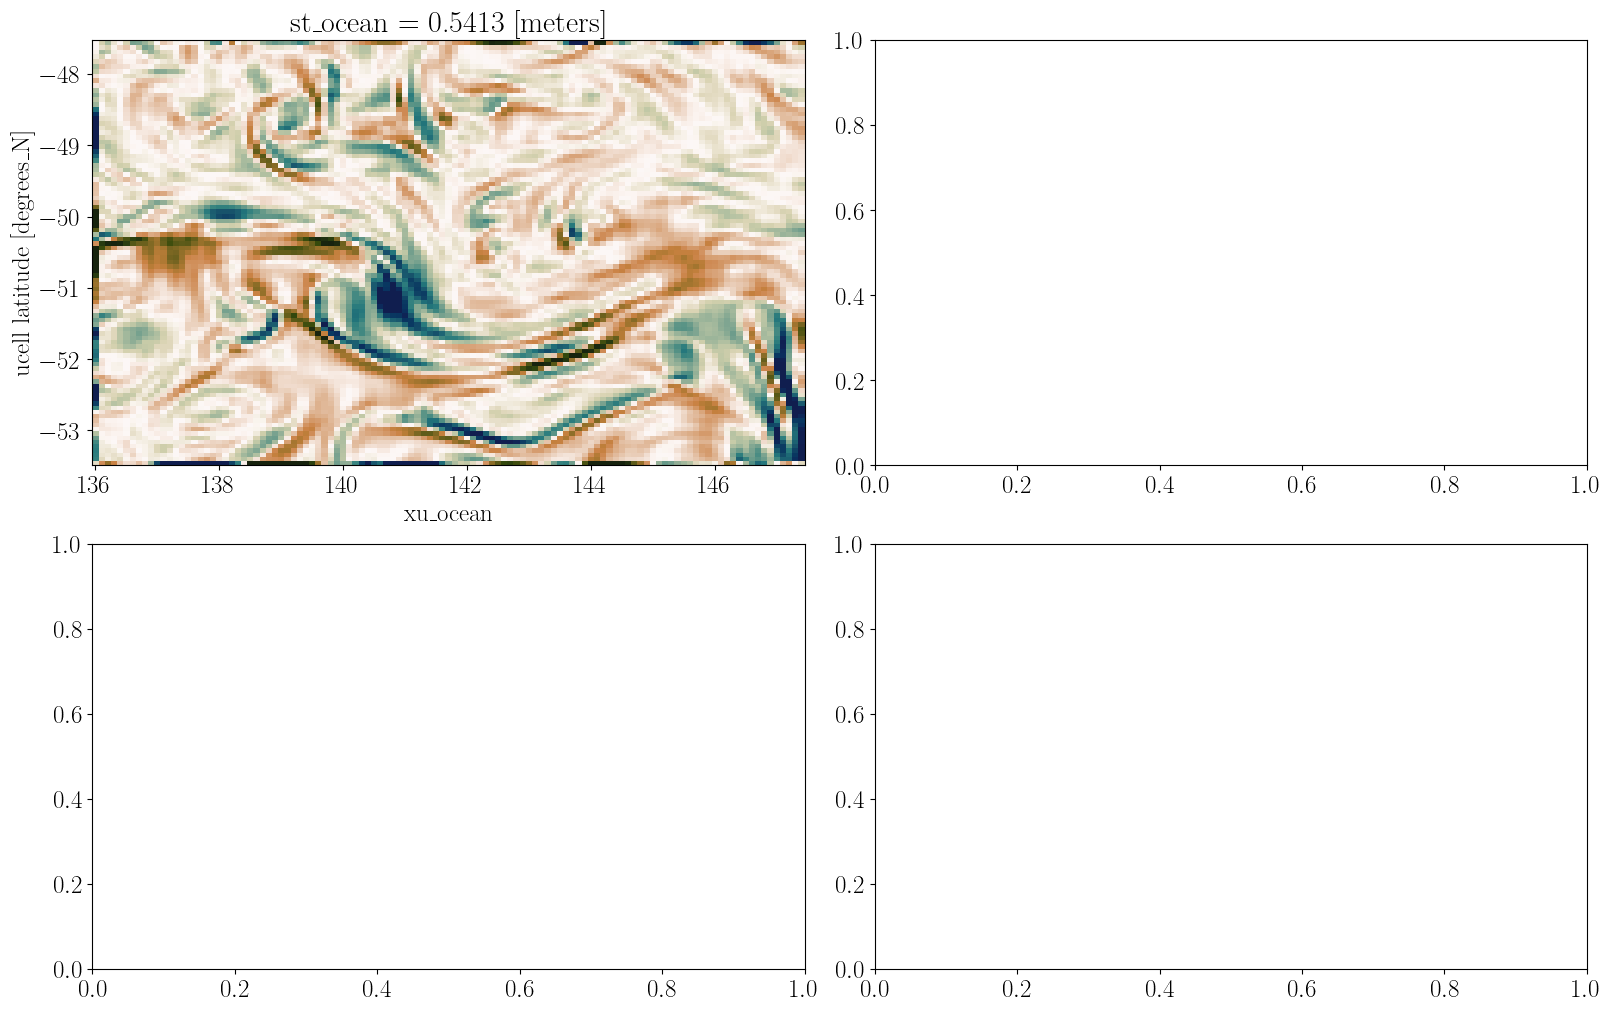

In [22]:
st_ocean_sel = [0, 100, 200]
nrows, ncols = 2, 2
slc = xt_ocean=slice(None, None, 3)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,10), constrained_layout=True)

# hor. divergence at 0m depth
pcol = div_u.sel(time=flex_period).mean('time').sel(st_ocean=st_ocean_sel[0], method='nearest').plot(ax=ax[0, 0],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)

quiv = gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[0, 0], x='xt_ocean', y='yt_ocean', u='dug', v='dvg', 
    units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], add_guide=False)

# hor. divergence at 30m depth
pcol = div_u.sel(time=flex_period).mean('time').sel(st_ocean=st_ocean_sel[1], method='nearest').plot(ax=ax[0, 1],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)

# quiv = gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
#     ax=ax[0, 1], x='xt_ocean', y='yt_ocean', u='dug', v='dvg', 
#     units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], add_guide=False)

# hor. divergence at 100m depth
pcol = div_u.sel(time=flex_period).mean('time').sel(st_ocean=st_ocean_sel[2], method='nearest').plot(ax=ax[1, 0],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)

# colorbar and quiver key
cbar = fig.colorbar(pcol, ax=ax[0, 1])
cbar.ax.set_ylabel(r'$\overline{\bf \nabla \cdot u}$', fontsize=fs_large)
qk = plt.quiverkey(quiv, 0.3, 0.98, 1, r'$1\:\mathrm{ms}^{-1}\:({\bf u - u_{g}})$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large}, transform=ax[0, 0].transAxes)

# scatter
lim = 4e-6
lightcolors = [plt.cm.get_cmap('tab20').colors[3], plt.cm.get_cmap('tab20').colors[5], plt.cm.get_cmap('tab20').colors[1]]
colors = ['tab:orange', 'tab:green', 'tab:blue']
for i, depth in enumerate(st_ocean_sel):
    # sel = ds_gw.sel(xt_ocean=slice(137,147), yt_ocean=slice(-53, -48)).sel(st_ocean=depth, method='nearest')
    sel = gw_core.sel(st_ocean=depth, method='nearest')
    sel.plot.scatter(ax=ax[1, 1], x='divua', y='divu', s=1, color=lightcolors[i], label=np.round(sel.st_ocean.values,1), zorder=-1+i)
    ax[1, 1].plot(*linear_fit(sel.divua, sel.divu), color=colors[i])
    if i == 0:
        ax[1, 1].text(0, 1.05, string.ascii_lowercase[iax] + '.)', 
                      transform=ax[1, 1].transAxes, size=fs_large)
    ax[1, 1].text(0.32*i+0.1, 1.05, r'$R^2 = %s$' %np.round(Rsquared(sel.divua.values, sel.divu.values)[0], 2), 
                  transform=ax[1, 1].transAxes, fontsize=fs_large, color=colors[i])
    ax[1, 1].set_xlabel(r'$\bf \nabla \cdot u_a$', fontsize=fs_large)
    ax[1, 1].set_ylabel(r'$\bf \nabla \cdot u$', fontsize=fs_large)


x = np.linspace(-lim, lim)
ax[1, 1].axhline(y=0, linestyle='--', color='gray', lw=0.5)
ax[1, 1].axvline(x=0, linestyle='--', color='gray', lw=0.5)
ax[1, 1].plot(x, x, '--', color='k', lw=0.5)
# ax[1, 1].set_xlim([-2.5e-6, 2.5e-6])
ax[1, 1].set_xlim([-lim, lim])
ax[1, 1].set_ylim([-lim, lim])
ax[1, 1].set_aspect('equal')
ax[1, 1].set_title('')

lgnd = ax[1, 1].legend(loc="lower right", fontsize=fs_large, title='Depth (m)')
for i, handle in enumerate(lgnd.legendHandles):
    handle.set_sizes([fs_small])
    handle.set_color(colors[i])
for i, text in enumerate(lgnd.texts):
    text.set_color(colors[i])
lgnd.get_title().set_fontsize(fs_small)

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols    

    if (r, c) != (1, 1):
        ax[r, c].text(0, 1.05, string.ascii_lowercase[iax] + 
                      '.) depth = %s m' %np.round(div_u.sel(st_ocean=st_ocean_sel[iax], method='nearest').st_ocean.values,1), 
                      transform=ax[r, c].transAxes, size=fs_large, color=colors[iax])
            
        cont = ds_gw.sea_level.mean('time').plot.contour(
            ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray')

        for ib, b in enumerate(sl_contours):
            if b in sl_contours[::2]:
                zc = cont.collections[ib]
                plt.setp(zc, linewidth=2)
        ax[r, c].clabel(cont, sl_contours[::2], inline=1, fmt='%.2f', fontsize=fs_small)

        ax[r, c].set_xlabel(r'Longitude ($^o$E)', fontsize=fs_large)
        ax[r, c].set_ylabel(r'Latitude ($^o$S)', fontsize=fs_large)
        ax[r, c].set_xlim([136, 147])
        ax[r, c].set_ylim([-53, -48])
        

ax[0, 0].set_xlabel('')
ax[0, 1].set_ylabel('')


In [ ]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, 'B1_validation-hor-divergence' + extension), 
                    transparent=transparent, bbox_inches='tight')

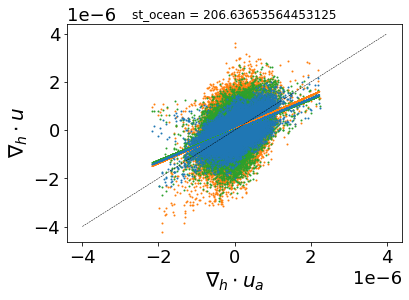

In [31]:
colors = ['tab:orange', 'tab:green', 'tab:blue']
for i, d in enumerate([0, 100, 500]):
    sel = gw_core.sel(st_ocean=d, method='nearest')
    sel.plot.scatter(x='divua', y='divu', s=1, color=colors[i])
    plt.plot(*linear_fit(sel.divua, sel.divu), color=colors[i])
x=np.linspace(-4e-6, 4e-6)
plt.plot(x, x, '--', color='k', lw=0.5)


0.3157781531420565


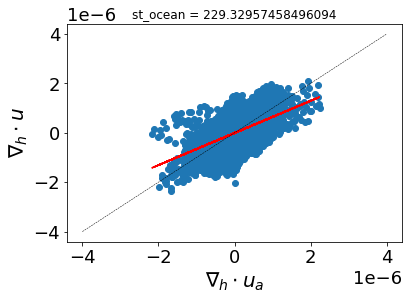

In [43]:
d = 230
sel = gw_core.sel(st_ocean=d, method='nearest')
sel.plot.scatter(x='divua', y='divu')
plt.plot(*linear_fit(sel.divua, sel.divu), color='r')
x=np.linspace(-4e-6, 4e-6)
plt.plot(x, x, '--', color='k', lw=0.5)
print(Rsquared(sel.divua.values, sel.divu.values)[0])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

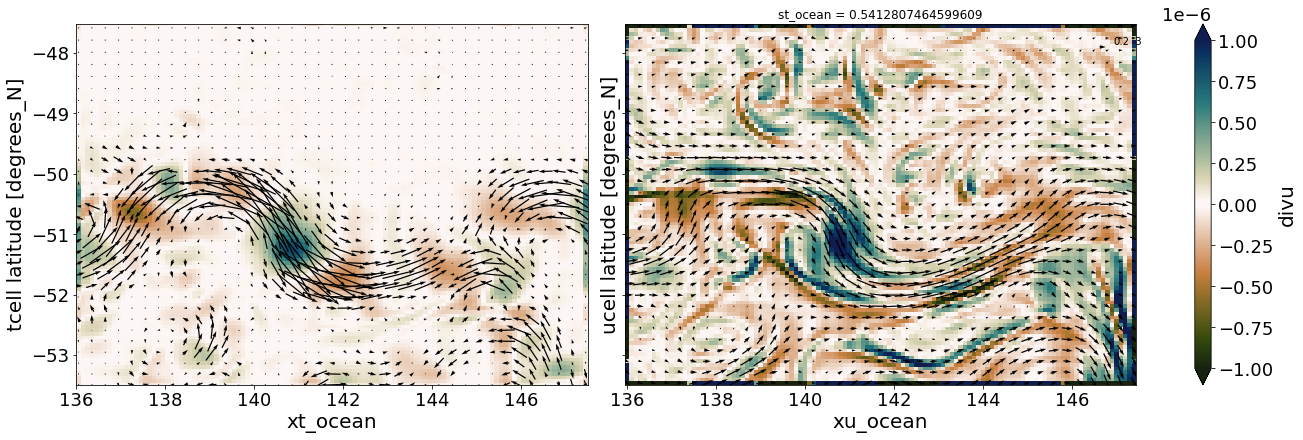

In [23]:
nrows, ncols = 1, 2
slc = slice(None, None, 3)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,6), 
                       sharey=True, constrained_layout=True)

slc = slice(None, None, 3)
div_u_gw.sel(time=flex_period).mean('time').plot(ax=ax[0],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)
quiv = gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[0], x='xt_ocean', y='yt_ocean', u='uag', v='vag')

div_u.sel(time=flex_period).mean('time').isel(st_ocean=0).plot(ax=ax[1],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6)
ds.sel(time=flex_period, xu_ocean=slc, yu_ocean=slc).mean('time').sel(st_ocean=0, method='nearest').plot.quiver(
    x='xu_ocean', y='yu_ocean', u='u', v='v')

# hor. divergence from total velocities
pcol = div_u.sel(time=flex_period).mean('time').isel(st_ocean=st_ocean_isel).plot(ax=ax[1, 1],
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)
cbar = fig.colorbar(pcol, ax=ax[1, 1])
cbar.ax.set_ylabel(r'$\overline{\bf \nabla \cdot u}$', fontsize=fs_large)


for iax in range(len(ax)):
    cont = gw.sea_level.mean('time').plot.contour(
        ax=ax[iax], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray')
    
    for ib, b in enumerate(sl_contours):
        if b in sl_contours[0::2]:
            zc = cont.collections[ib]
            plt.setp(zc, linewidth=2)
    ax[iax].clabel(cont, sl_contours[0::2], inline=1, fmt='%.2f')
    
    ax[iax].set_xlabel(r'Longitude ($^o$E)', fontsize=fs_large)
    ax[iax].set_ylabel(r'Latitude ($^o$S)', fontsize=fs_large)
ax[1].set_ylabel('')

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

In [22]:
fig, ax = plt.subplots()

# hor. divergence from total velocities
pcol = div_u.sel(time=flex_period).mean('time').isel(st_ocean=0).plot(ax=ax,
    cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)
cbar = fig.colorbar(pcol, ax=ax)
cbar.ax.set_ylabel(r'${\bf \nabla \cdot u}$', fontsize=fs_large)

quiv = gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax, x='xt_ocean', y='yt_ocean', u='dugw', v='dvgw', 
    units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], add_guide=False)
qk = plt.quiverkey(quiv, 0.76, 0.48, 1, r'$1\:\mathrm{ms}^{-1}\:({\bf u - u_{gw}})$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})

RuntimeError: latex was not able to process the following string:
b'tcell longitude [degrees_E]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (TeX Live 2018) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode

(/home/581/jm6603/.cache/matplotlib/tex.cache/1f5fbeb57321c4571becdd0d306dd418.
tex
LaTeX2e <2017-04-15>
Babel <3.17> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amsfonts.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amssymb.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 1f5fbeb57321c4571becdd0d306dd418.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.21 {\rmfamily tcell longitude [degrees_
                                         E]}
No pages of output.
Transcript written on 1f5fbeb57321c4571becdd0d306dd418.log.




<Figure size 432x288 with 2 Axes>

## Normal and shear strain

In [23]:
plt.rcParams.update(plt.rcParamsDefault)

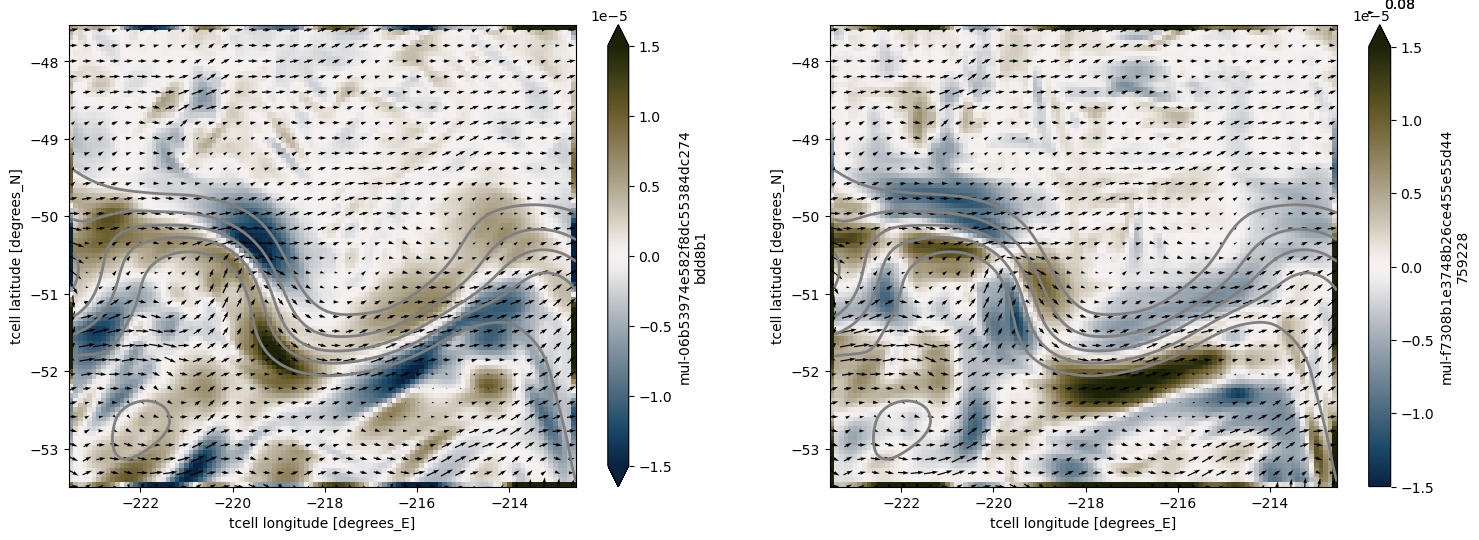

In [24]:
sn, ss, sigma = horizontal_strain(ds, grid)
zeta = relative_vorticity(ds, grid)

fig, ax = plt.subplots(figsize=(18,6), ncols=2)
slc = slice(None, None, 3)

sn.sel(time=flex_period).mean('time').sel(st_ocean=0, method='nearest').plot(ax=ax[0],
    cmap=cmo.cm.diff, vmin=-1.5e-5, vmax=1.5e-5)
ss.sel(time=flex_period).mean('time').sel(st_ocean=0, method='nearest').plot(ax=ax[1],
    cmap=cmo.cm.diff, vmin=-1.5e-5, vmax=1.5e-5)

sl_contours = np.linspace(-0.6, -0.1, 5)
for iax in range(ax.size):
    gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
        ax=ax[iax], x='xt_ocean', y='yt_ocean', u='dugw', v='dvgw', color='k')
#     ds.sel(time=flex_period, xu_ocean=slc, yu_ocean=slc).mean('time').sel(st_ocean=0, method='nearest').plot.quiver(
#         ax=ax[iax], x='xu_ocean', y='yu_ocean', u='u', v='v')
    cont = ds.sea_level.mean('time').plot.contour(
            ax=ax[iax], levels=sl_contours, linestyles='solid', linewidths=2, colors='gray')

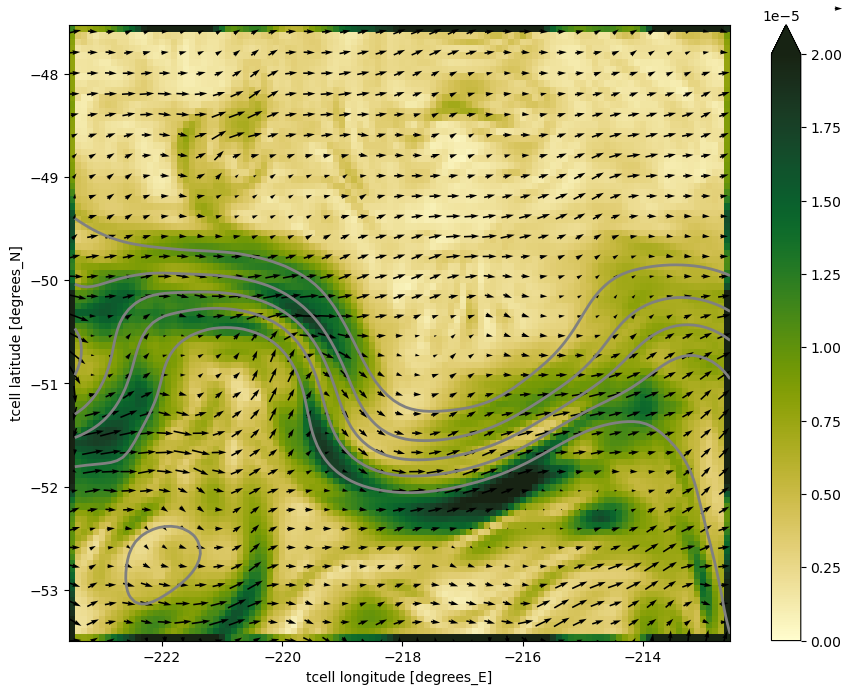

In [25]:
sigma.sel(time=flex_period).mean('time').sel(st_ocean=0, method='nearest').plot(
    size=8, cmap=cmo.cm.speed, vmin=0, vmax=2e-5)
gw.mean('time').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    x='xt_ocean', y='yt_ocean', u='dugw', v='dvgw', color='k')
cont = ds.sea_level.mean('time').plot.contour(
    levels=sl_contours, linestyles='solid', linewidths=2, colors='gray')



### Okubo-Weiss parameter

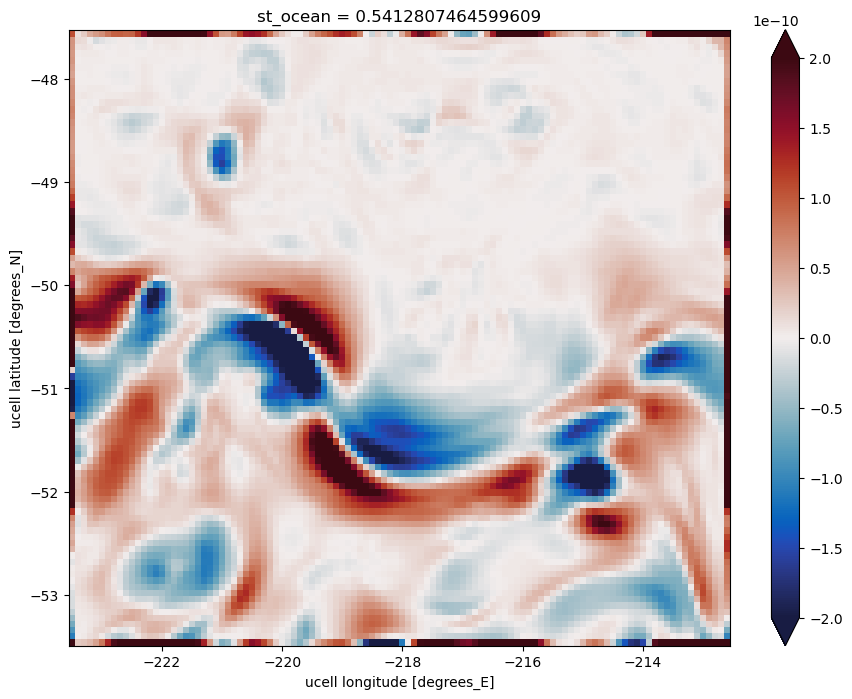

In [26]:
(sn**2 + ss**2 - zeta**2).sel(time=flex_period).mean('time').sel(st_ocean=0, method='nearest').plot(
    size=8, cmap=cmo.cm.balance, vmin=-2e-10, vmax=2e-10)

## Joint Probability Density Function

In [27]:
from gsw import f
fu = np.broadcast_to(f(gw.yu_ocean).values[np.newaxis].T, gw.utot.shape[1:])
ft = np.broadcast_to(f(gw.yt_ocean).values[np.newaxis].T, gw.utott.shape[1:])